## Model Pipeline
**Data preprocessing**: Resize to 60x60

**Model**: Following ResNet transfer learning implementation from this [blog](https://medium.com/swlh/resnet-with-tensorflow-transfer-learning-13ff0773cf0c)

In [1]:
!pip install pickle5

In [2]:
# import libraries
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, losses, optimizers, regularizers, callbacks

import os
import time
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

import cv2
from scipy.ndimage import median_filter
from skimage.transform import resize as sk_resize
from skimage.util import img_as_ubyte
from skimage.morphology import skeletonize, thin

import helpers as helper
from keras_model_s3_wrapper import *

import boto3
import pickle5 as pickle
s3 = boto3.resource('s3')
bucket_name = 'wafer-capstone'
my_bucket = s3.Bucket(bucket_name)

In [3]:
tf.__version__

'2.3.4'

In [4]:
tf.config.list_physical_devices(device_type=None)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Load the data
Dataset must have the following columns: 
- **waferMap**: defect data of wafer map where 0 = blank spot, 1 = normal die (passed the electrical test), and 2 = broken die (failed electrical test); data type must be np.uint8
- **ID**: unique identification for each waferMap, separate from dataframe index

If labeled, dataset must have the following columns:
- **detectLabels**: for evaluating the detect model, where 0 = no defect, 1 = defect
- **classifyLabels**: for evaluating the classify model, where 0 = Loc, 1 = Edge-Loc, 2 = Center, 3 = Edge-Ring, 4 = Scratch, 5 = Random, 6 = Near-full, 7 = Donut, 8 = none

In [5]:
# specify variables

# specify data to load
path = 'processed_data/customer'
filename = 'MixedWM38-single'
labeled = True

# # where to save results
# result_path = ''
# result_filename = ''

# which models to run
model = 'resnet-all60'

In [6]:
# load data directly from S3 (using boto3 resource)
start = time.time()

data_key = f'{path}/{filename}.pkl'
data = pickle.loads(my_bucket.Object(data_key).get()['Body'].read())

print("Wall time: {:.2f} seconds".format(time.time() - start))
print(f"Dataset length: {len(data)}")

Wall time: 0.67 seconds
Dataset length: 8015


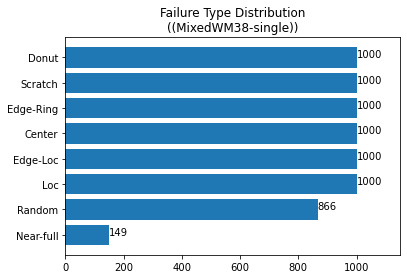

In [7]:
# IF LABELED
# show failure type distribution
if labeled:
    data_defects = data[data.detectLabels == 1]
    helper.defect_distribution(data_defects, note=f'({filename})')

### Data preprocessing

In [8]:
# resize to 60x60
start = time.time()

def preprocess(x):
    y = sk_resize(x, [60 ,60])
    new_y = img_as_ubyte(y)
    return new_y
    
data['waferMap224'] = data.waferMap.apply(lambda x: preprocess(x))

print("Wall time: {:.2f} seconds".format(time.time() - start))
print("Sanity checks:")
print(f'Map shape: {data.waferMap224[0].shape}')

Wall time: 6.20 seconds
Sanity checks:
Map shape: (60, 60)


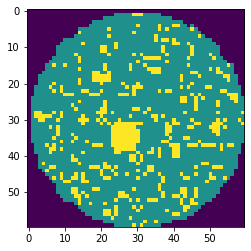

In [9]:
plt.imshow(data.waferMap224[0])

### GoogLeNet Model

##### Data set-up

In [10]:
# prepare inputs
start = time.time()

x_det = np.stack(data['waferMap224'])
x_det = tf.expand_dims(x_det, axis=3, name=None)
x_det = tf.repeat(x_det, 3, axis=3)

print("Wall time: {:.2f} seconds".format(time.time() - start))
# sanity check
# expected: TensorShape([#rows, xdim, ydim, 1])
x_det.shape

Wall time: 1.22 seconds


TensorShape([8015, 60, 60, 3])

In [11]:
# IF LABELED
# prepare labels for evaluating results
if labeled:
    y_det = np.asarray(data['classifyLabels']).astype(np.uint8)

##### Load and run model

In [12]:
# load saved detect model from S3
start = time.time()

resnet = s3_get_keras_model(model)
resnet.summary()

print("Wall time: {:.2f} seconds".format(time.time() - start))

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60, 60, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 66, 66, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 30, 30, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 30, 30, 64)   256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [13]:
# generate predictions
start = time.time()

resnet_pred = resnet.predict(x_det)
resnet_labels = np.argmax(resnet_pred, axis=1).astype(np.uint8)

print("Wall time: {:.2f} seconds".format(time.time() - start))

Wall time: 11.36 seconds


Overall Model Accuracy: 52.24%


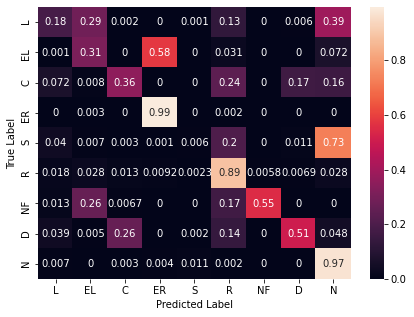

In [14]:
# IF LABELED
if labeled: 
    y_test = data['classifyLabels'].tolist()
    
    # manually compute overall accuracy
    resnet_cm = confusion_matrix(y_test, resnet_labels)

    num = 0
    for i in range(9):
        num += resnet_cm[i][i]

    overall_accuracy = num / len(y_test) * 100
    print(f'Overall Model Accuracy: {overall_accuracy:.2f}%') 

    # plot confusion matrix
    helper.plot_confusion_matrix(y_test, resnet_labels, mode='all', normalize=True)

### Error Analysis

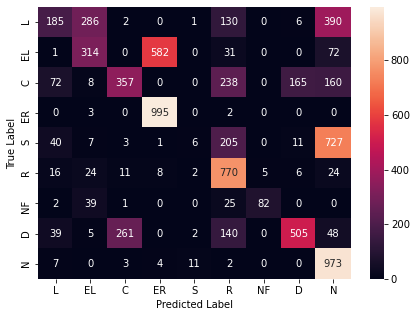

In [15]:
# IF LABELED
# plot confusion matrix counts
if labeled:
    helper.plot_confusion_matrix(y_test, resnet_labels, mode='all', normalize=False)